In [2]:
print("retest")

# FOLD = '/content/'
FOLD = '/kaggle/working/'
import os

retest


In [3]:
import shutil

# Function to remove a folder and its contents
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Folder {path} and its contents successfully removed.")
    except OSError as e:
        print(f"Error: {e.strerror}")

# Specify the path of the folder to be removed
folder_path = os.path.join(FOLD, 'dataset')

# Call the function to remove the folder
remove_folder(folder_path)

Folder /kaggle/working/dataset and its contents successfully removed.


In [3]:
!git clone https://github.com/QuanHoangNgoc/Container.git dataset

Cloning into 'dataset'...
remote: Enumerating objects: 6739, done.
remote: Total 6739 (delta 0), reused 0 (delta 0), pack-reused 6739
Receiving objects: 100% (6739/6739), 140.80 MiB | 42.87 MiB/s, done.
Updating files: 100% (7024/7024), done.


In [5]:
DIR = '/kaggle/input/brain-tumor-detection/'
os.listdir(DIR)


['no', 'yes', 'Br35H-Mask-RCNN', 'pred']

# "Source Code"

## --Const

In [6]:
######################################################################################
# Const
######################################################################################
CLEAR_LOG = True  # clear file log (if need)
example_code = True

TYPE = 'COLOR'
SIZE = (240, 240)
VALUE = [0, 255]


In [7]:
######################################################################################
# Set Up
######################################################################################
import skimage as ski
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import math


if (example_code):
    print("ski version: ", ski.__version__)
    print("numpy version: ", np.__version__)
    print("pandas version: ", pd.__version__)
    print("sklearn version: ", skl.__version__)


ski version:  0.22.0
numpy version:  1.26.4
pandas version:  2.2.2
sklearn version:  1.2.2


In [8]:
######################################################################################
# Utils
######################################################################################
import logging
from absl import logging as absl_logging
from skimage import io, exposure
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import inspect


######################################################################################################
# NORMAL UTIL
######################################################################################################
def get_current_method_name(index=2):
    current_frame = inspect.stack()[index]
    method_name = current_frame.function
    return "<" + method_name + ">"


NUM_PRT_SC = int(1e18)


def setup_logging():
    # Set the log file path
    _log_file = os.path.join(os.getcwd(), '_log')
    if not os.path.exists(_log_file):
        os.makedirs(_log_file)
    _log_file = os.path.join(_log_file, 'log.txt')
    if (CLEAR_LOG and os.path.exists(_log_file)):
        os.remove(_log_file)

    # format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    # Configure the Python logging to write to the log file
    logging.basicConfig(filename=_log_file, level=logging.INFO, format=None)
    # Redirect absl logging to the Python logging
    absl_logging.use_python_logging()
    absl_logging.info("\n\n")


setup_logging()


class ut:
    _active = True

    def __init__(self):
        pass

    def act(active):
        ut._active = active
        global NUM_PRT_SC
        if NUM_PRT_SC > 2:
            NUM_PRT_SC = 2
        else:
            NUM_PRT_SC = int(1e18)

    def prt_section():
        global NUM_PRT_SC
        if NUM_PRT_SC < 1:
            return
        else:
            NUM_PRT_SC -= 1
        logging.info("~" * int(77 * 1))
        print("~" * int(77 * 1), flush=True)

    def mess(*mess):
        if ut._active == False:
            return
        ut.prt_section()
        out = '# '
        func_dir = get_current_method_name()
        if (func_dir not in ['<over>', '<note_verbose>']):
            out += get_current_method_name() + "\n"

        for arg in mess:
            out += str(arg) + " "
        global absl_logging
        absl_logging.info(out)
        print(out, flush=True)
        ut.prt_section()

    def note_verbose(flag, title):
        if ut._active == False:
            return
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__verbose__:", func_dir, "\n", "@@@", title)
        # ut.prt_section()

    def over(val, var_name=None):
        if ut._active == False:
            return
        if var_name == None:
            var_name = "{}".format(get_current_method_name())
        else:
            var_name = "{1} \n [{0}]".format(var_name,
                                             get_current_method_name())
        # ut.prt_section()
        try:
            ratio = val.std()**2/(val.max()-val.min()) * 100
            ratio = round(ratio, 2)
            ut.mess(
                "__var__:",
                var_name + "\n",
                [(val.dtype, type(val)), val.shape], "\n",
                [(val.min(), val.max()), (val.mean(),
                                          val.std() ** 2, str(ratio) + " %")], "\n",
                [np.sum(np.isnan(val)), str(
                    round(sys.getsizeof(val)/10**6, 2)) + " Mb"],
            )
        except:
            try:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), len(val), "no-min-max-mean"),
                )
            except:
                ut.mess(
                    "__var__:",
                    var_name + "\n",
                    (type(val), "no-shape", "no-min-max-mean"),
                )
        # ut.prt_section()

    def error(tilte):
        func_dir = get_current_method_name()
        # ut.prt_section()
        ut.mess("__error__:", func_dir, "@@@", tilte)
        # ut.prt_section()
        assert 1 == 0


In [9]:
######################################################################################################
# SKI UTIL
######################################################################################################
def retype_image(image: np.ndarray, istype: str):
    if (istype not in ['float', 'ubyte', 'int']):
        ut.error()
    if (istype == 'float'):
        return ski.util.img_as_float(image)
    if (istype == 'ubyte'):
        return ski.util.img_as_ubyte(image)
    if (istype == 'int'):
        return ski.util.img_as_int(image)
    ut.error()


def revalue_image(image, in_range, out_range):
    return ski.exposure.rescale_intensity(image, in_range=in_range, out_range=out_range)


def show_image(image: np.ndarray, choose=1):
    try:
        assert (choose == 0)
        out = ski.util.img_as_uint(image) # Convert to int
        plt.imshow(out)
        plt.axis('off')  # Optional: to hide the axis
        plt.show()
    except:
        # Display the image using skimage's viewer
        out = ski.util.img_as_uint(image) # Convert to int
        print('cmap = gray')
        plt.imshow(out, cmap='gray')
        plt.axis('off')  # Optional: to hide the axis
        plt.show()


def read_image(path: str, as_gray=True):
    image = ski.io.imread(path, as_gray=as_gray)
    image = ski.img_as_float(image)
    return image

def recolor_image(image, channel):
    if (channel not in ['gray', 'rgb']):
        ut.error()
    if (channel == 'gray'):
        return ski.color.rgb2gray(image)
    if (channel == 'rgb'):
        return ski.color.gray2rgb(image)
    ut.error()


def show_his(image):
    try:
        colors = ('red', 'green', 'blue')
        for color, channel in zip(colors, image.transpose((2, 0, 1))):
            hist, hist_centers = exposure.histogram(channel)
#             hist /= len(hist.flatten())
            plt.fill_between(hist_centers, hist, label=color, alpha=0.3)
        plt.legend()
        plt.title('Histogram for Each Color Channel')
    except:
        # Compute the histogram
        hist, hist_centers = exposure.histogram(image)
#         hist /= len(hist.flatten())
        # Display the histogram
        plt.fill_between(hist_centers, hist, alpha=0.3)
        plt.title('Histogram of Grayscale Image')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
    plt.show()


In [10]:
######################################################################################################
# Random files
######################################################################################################
import random
def get_random_file_in_folder(root_folder, K):
    lis = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            lis.append(file_path)
    random.shuffle(lis)
    return lis[:K]


# Data

In [18]:
import json 
from collections import defaultdict 


with open(DIR + '/Br35H-Mask-RCNN/annotations_all.json', 'r') as file:
    # Load the JSON data from the file
    jfile = json.load(file)
    
    
loc_datadict = defaultdict(list)
print("len of jfile: ", len(jfile))
for key_row in jfile.keys():
    dic = jfile[key_row]
    filename = dic["filename"]
    regions = dic["regions"]
    if(len(regions) > 1): 
        continue
    else: 
        region = regions[0]
    if(region["shape_attributes"]["name"] != "polygon"): continue 
    x_list = region["shape_attributes"]["all_points_x"]
    y_list = region["shape_attributes"]["all_points_y"]
    loc_datadict[filename] = (x_list, y_list)

print()
print("len of loc_datadict: ", len(loc_datadict))


yes_list = list(loc_datadict.keys())
yes_list = sorted(yes_list) 
# print(yes_list)


len of jfile:  801

len of loc_datadict:  527


In [19]:
from skimage import color, io
import cv2
from sklearn.model_selection import train_test_split
SIZE = (240, 240, 3)
VALUE = 'ubyte'


def create_loc_data(num_few=32, seed=42): 
    X, Y = [], []  
    for filename in yes_list: 
        path = os.path.join(DIR + '/yes', filename) 
        org_image = io.imread(path) # Color 

        image = org_image.copy()
        x_list, y_list = loc_datadict[filename]
        polygon_points = np.array([[x_list[i], y_list[i]] for i in range(len(x_list))])
        # Draw the polygon on the image
        cv2.polylines(image, [polygon_points], isClosed=True, color=(255, 255, 255), thickness=2)
        # Find the bounding rectangle around the polygon
        x, y, w, h = cv2.boundingRect(polygon_points)
        # Draw the bounding box on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Resize image -> Retype image 
        org_image = ski.transform.resize(org_image, SIZE, anti_aliasing=True)
        org_image = retype_image(org_image, 'ubyte')
        
        cen = (x + w/2, y + h/2) # x -> [1], y -> [0] 
        cen = [cen[0] * 240 / image.shape[1], cen[1] * 240 / image.shape[0]]
        # Swap into grid coor 
        cen = [int(cen[1]), int(cen[0])]
        
        X.append(org_image)
        Y.append(cen)
        
    X, Y = np.array(X), np.array(Y)
    _, X, _, Y = train_test_split(X, Y, test_size=num_few, random_state=seed)
    return X, Y 


In [20]:
if(example_code):
    X, Y = create_loc_data()
    ut.over(X, "X")
    ut.over(Y, "Y")
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [X]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (32, 240, 240, 3)] 
 [(0, 255), (83.29230179398148, 6231.151307346423, '2443.59 %')] 
 [0, '5.53 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [Y]
 [(dtype('int64'), <class 'numpy.ndarray'>), (32, 2)] 
 [(54, 207), (114.484375, 1508.3122558593752, '985.83 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


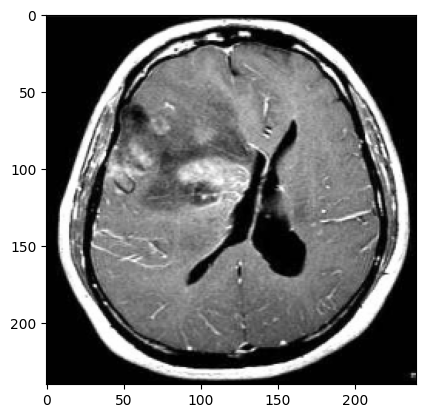

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
28 [92 86] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [23]:
if(example_code): 
    i = random.randint(0, len(X))
    plt.imshow(X[i])
    plt.show()
    ut.mess(i, Y[i])
    

# MDP State to State 

In [29]:
C = 4
B = 240 // C 

cen_label = [None for i in range(C*C)] 
for i in range(C): 
    for j in range(C): 
        cen_label[i*C + j] = [i*B + B//2, j*B + B//2]

cen_label = np.array(cen_label)


THRES = float(3200.0)
def sqr2points(a, b): 
    return (a[0]-b[0])**2 + (a[1]-b[1])**2 


cen_label


array([[ 30,  30],
       [ 30,  90],
       [ 30, 150],
       [ 30, 210],
       [ 90,  30],
       [ 90,  90],
       [ 90, 150],
       [ 90, 210],
       [150,  30],
       [150,  90],
       [150, 150],
       [150, 210],
       [210,  30],
       [210,  90],
       [210, 150],
       [210, 210]])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [3]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (104.86710069444445, 6268.1524940245845, '2458.1 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


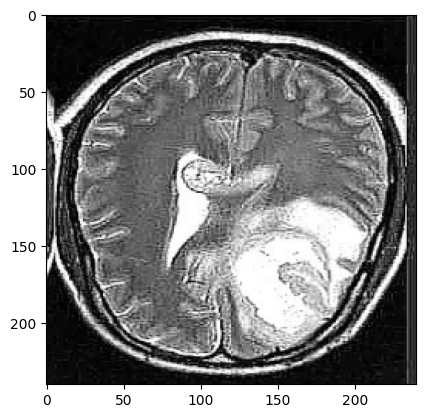

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
[169 163] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [25]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (80.75177083333334, 5322.460222558593, '2087.24 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


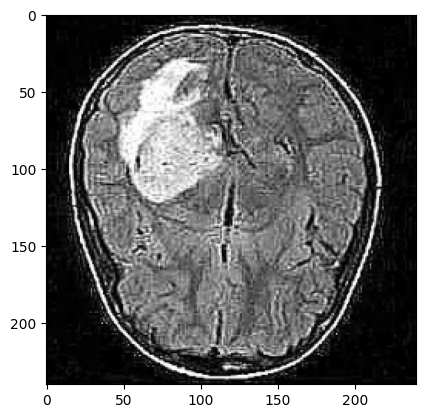

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
[76 82] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [19]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (69.14342013888889, 4773.07285080265, '1871.79 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


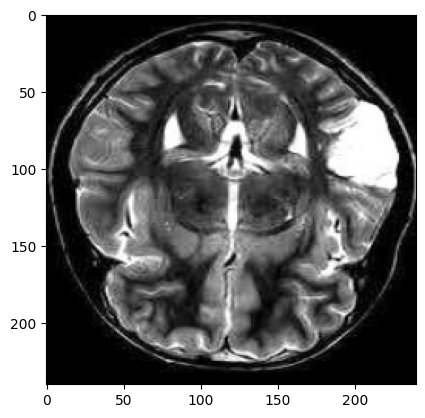

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
[ 86 207] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [27]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 254), (63.87703125, 3859.680277992079, '1519.56 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


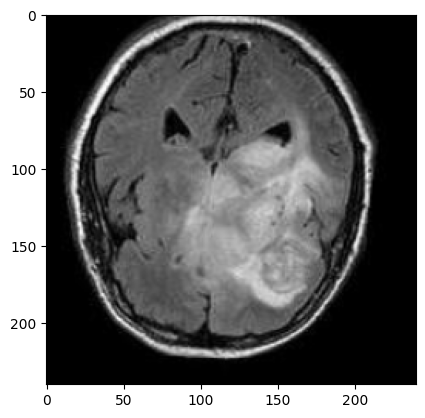

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
[136 132] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [12]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (240, 240, 3)] 
 [(0, 255), (94.63348958333333, 5408.585374975588, '2121.01 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


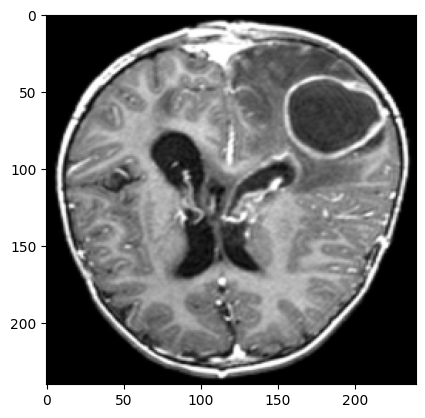

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <<module>>
[ 66 188] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [33]:
if(example_code):
    lis = [x for x in range(len(X))]
    random.shuffle(lis)
    lis = lis[:5]
    
    for i in lis:
        image = X[i]
        ut.over(image, str(i))
        plt.imshow(image)
        plt.show()
        ut.mess(Y[i])


## DQN 

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random


# Define the network architecture
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        
        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(state_size, 512), # vector instead of image 
            nn.ELU(),
            nn.Linear(512, 256),
            nn.ELU(),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, action_size)
        )
        
        # Initialize the weights using Glorot uniform initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.dense_layers(x)
        return x


# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.index = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.index] = (state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in batch:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return (
            torch.tensor(np.array(states)).float().to(device),
            torch.tensor(np.array(actions)).long().to(device),
            torch.tensor(np.array(rewards)).unsqueeze(1).float().to(device),
            torch.tensor(np.array(next_states)).float().to(device),
            torch.tensor(np.array(dones)).unsqueeze(1).int().to(device)
        )

    def __len__(self):
        return len(self.buffer)


# Define the Double DQN agent
class DDQNAgent:
    def __init__(self, state_size, action_size, seed, learning_rate=1e-3, capacity=1000000,
                 discount_factor=0.99, tau=1e-3, update_every=4, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.steps = 0

        self.qnetwork_local = QNetwork(state_size, action_size)
        self.qnetwork_target = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(capacity)
        self.update_target_network()

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)

        # Learn every update_every steps
        self.steps += 1
        if self.steps % self.update_every == 0:
            if len(self.replay_buffer) > self.batch_size:
                experiences = self.replay_buffer.sample(self.batch_size)
                self.learn(experiences)

    def act(self, state, eps=0.0):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.qnetwork_local.to(device)
        self.qnetwork_target.to(device)
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + self.discount_factor * (Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.view(-1, 1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

    def update_target_network(self):
        # Update target network parameters with polyak averaging
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
            

# Curriculum Learning

In [35]:
x_test, y_test = create_loc_data(num_few=500) 

ut.over(x_test, "x_test")
ut.over(y_test, "y_test")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [x_test]
 [(dtype('uint8'), <class 'numpy.ndarray'>), (500, 240, 240, 3)] 
 [(0, 255), (91.43421353009259, 6579.2211719552, '2580.09 %')] 
 [0, '86.4 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>> 
 [y_test]
 [(dtype('int64'), <class 'numpy.ndarray'>), (500, 2)] 
 [(32, 210), (118.977, 1653.6624709999996, '929.02 %')] 
 [0, '0.01 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [36]:
from skimage.feature import hog
import numpy as np
from skimage import color

orientations = 9   # Number of gradient orientations
pixels_per_cell = (8, 8)  # Size of a cell in pixels
cells_per_block = (2, 2)  # Number of cells per block


def get_hog_feature(x_arr): 
    lis = [] 
    for i in range(len(x_arr)):
        x = x_arr[i] 
        gray_image = color.rgb2gray(x)
        hog_features, hog_image = hog(gray_image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True)
        lis.append(hog_features)
    return np.array(lis)


In [37]:
x_test = get_hog_feature(x_test)

In [38]:
x_arr, x_test, y_arr, y_test = train_test_split(x_test, y_test, test_size=300, random_state=42)


In [39]:
ut.over(x_arr)
ut.over(y_arr)
ut.over(x_test)
ut.over(y_test)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (200, 30276)] 
 [(0.0, 0.9999999987499999), (0.11298593956596263, 0.013641893133623207, '1.36 %')] 
 [0, '48.44 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('int64'), <class 'numpy.ndarray'>), (200, 2)] 
 [(33, 205), (119.705, 1553.382975, '903.13 %')] 
 [0, '0.0 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# __var__: <<module>>
 [(dtype('float64'), <class 'numpy.ndarray'>), (300, 30276)] 
 [(0.0, 0.9999999987499999), (0.11242936129548525, 0.013536258254357445, '1.35 %')] 
 [0, '72.66 Mb'] 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~

In [44]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", DEVICE)


def eval_testset(model, x_test, y_test): 
    states = torch.FloatTensor(x_test).to(DEVICE)
    actions = model(states).argmax(dim=1).cpu().numpy() # (n,) np 
    cen_predictions = cen_label[actions] # (n, 2) np 
    res = (cen_predictions - y_test)**2 
    res = res.sum(axis=1) # (n,) np 
    correct = np.sum(res <= THRES) 
    ut.mess("acc: ", correct, len(res))
    return correct


Device is:  cuda


In [45]:
def train_dqn(): 
    # Get the state and action sizes
    state_size = x_arr[0].shape[0]
    action_size = C*C 
    # Set the random seed
    seed = 42 
    # Create the DDQN agent
    agent = DDQNAgent(state_size, action_size, seed)
    # Set the number of episodes and the maximum number of steps per episode
    num_episodes = 1000
    max_steps = 40 

    # Set the exploration rate
    eps = eps_start = 1.0
    eps_end = 0.01
    eps_decay = 0.995

    # Set the rewards and scores lists
    his_train = []
    his_test = []
    random_list = [x for x in range(len(x_arr))] * 100 

    # Run the training loop
    for i_episode in range(num_episodes):
        # Initialize the environment and the state
        idx = random_list[i_episode]
        state = x_arr[idx]
        # eps = eps_end + (eps_start - eps_end) * np.exp(-i_episode / eps_decay)
        # Update the exploration rate
        eps = max(eps_end, eps_decay * eps)

        # Run the episode
        for t in range(max_steps):
            # Select an action and take a step in the environment
            action = agent.act(state, eps)
            
            # interact with mdp 
            next_state = state.copy() 
            res = sqr2points(y_arr[idx], cen_label[action])
            if(res <= THRES): reward = +1.0 
            else: reward = -0.5 * res / THRES 
            done = False 
            
            # Store the experience in the replay buffer and learn from it
            agent.step(state, action, reward, next_state, done)
            # Update the state and the score
            state = next_state
            
        if(i_episode % 10): 
            his_train.append(eval_testset(agent.qnetwork_local, x_arr, y_arr))
            his_test.append(eval_testset(agent.qnetwork_local, x_test, y_test))
            ut.mess("eps: ", eps)
            
    return agent, his_train, his_test


In [46]:
agent, his_train, his_test = train_dqn()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <eval_testset>
acc:  16 200 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <eval_testset>
acc:  27 300 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <train_dqn>
eps:  0.990025 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <eval_testset>
acc:  90 200 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <eval_testset>
acc:  117 300 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

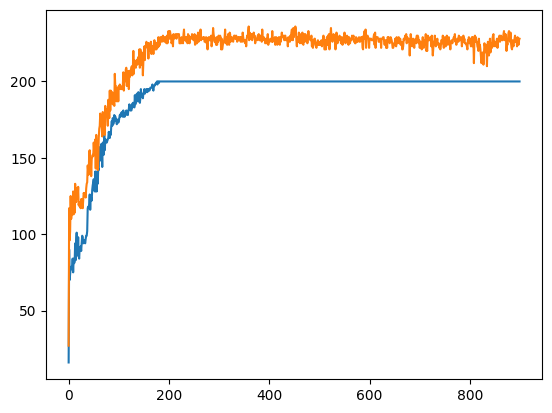

In [47]:
plt.plot(his_train)
plt.plot(his_test)

df_save = pd.DataFrame({'200_300_train': his_train, '200_300_test': his_test})
df_save.to_csv('result.csv')


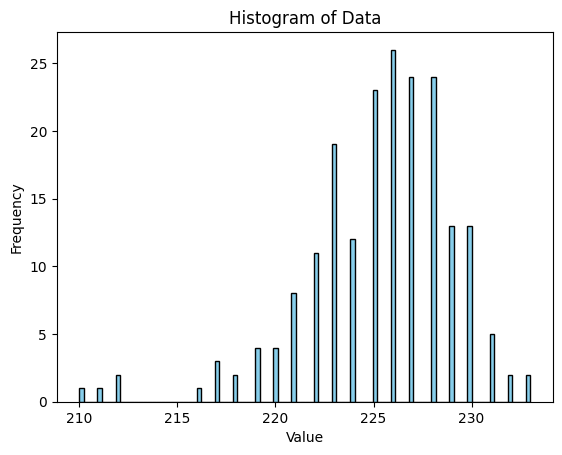

225.31

In [51]:
data = his_test.copy()
data = data[-200:]

plt.hist(data, bins=100, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()
np.mean(data)


In [52]:
trained_dqn = agent.qnetwork_local

In [53]:
eval_testset(trained_dqn, x_test, y_test)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# <eval_testset>
acc:  228 300 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


228

In [67]:
def get_dispoints(x_test, y_test): 
    dispoints = []
    for i in range(len(x_test)):
        x, y = x_test[i], y_test[i]
        action = agent.act(x)
        cen_pred = cen_label[action]
        dispoints.append(np.sqrt(sqr2points(y, cen_pred))) 
    return np.round(dispoints, 0) 


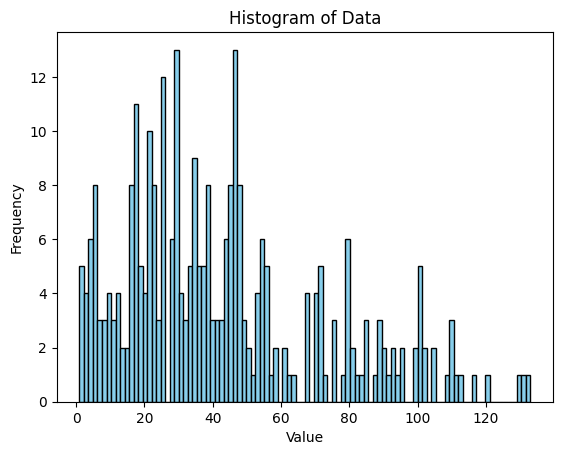

[ 39.  85.  22.  68. 104.  32.   4.  17.  55.  72.  19.  26.  17.  24.
  48.  47.  19.  47.  31.  10.  22.  44.  50.  25.  31.  83.  29.   4.
  46.   4.  20.  46.  56.  47.   6.  36.  33.  71.  35.  48.  23.  39.
  37.  13.  21.  70.  39.   5.  30.  16.  16.   5.  29.   2.  25.  70.
  49.  37.  67.  40.  80.  71.  45.  45.  29.  29.  55.  64.  22.  17.
 130.  16.  56.  30.  25.  22.  15.  75.  12.  44.  38. 112.  24.  11.
  25.   8.  19.  41.  68.  33.   5.   4.  80.  53.   5.  75.  28.  16.
  38.   7.  95.  89. 133.  44.   2.   7.  30.  21. 117.  11.  57.  25.
  36.  16.  20.  99.  76.  56.   3.  38.  41.  23.  47.  46.  44.  93.
  45.   1.  89.  44.  37. 110.  41.  16.  85.  15.  23.  36.   8.  53.
  54.  31.  19.  26. 131.  17.  47.   1.  61.  45.  45.  23.  11.  30.
 100.  80.  23.  25.  91.  40.   3.  45.  35.  80.  23.  49.  81.  34.
  28.  53.  33.  59.  35.  99.   3.   5.  31.  48.  85.  33.  24.  45.
  17. 102.   7.  47. 100.  56. 101.  48.  36.  20.  12.   4.  12.  38.
  16. 

In [68]:
data = get_dispoints(x_test, y_test).copy()

plt.hist(data, bins=100, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()
np.mean(data)
print(data)


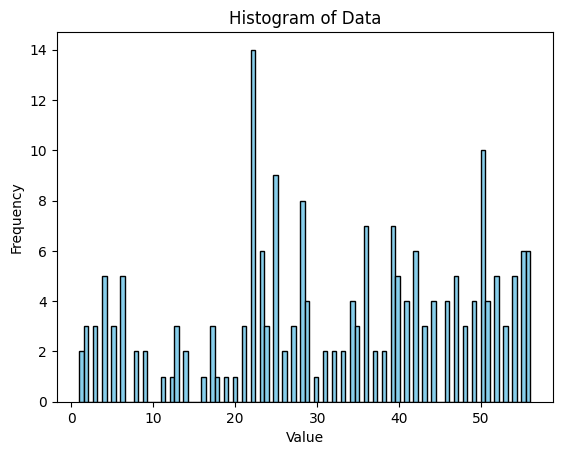

[41.  6. 53. 40. 50. 56.  3. 56. 50. 28. 32. 12. 46. 22. 17. 54. 26. 36.
 53. 11. 49. 44. 56. 23.  3. 36. 37. 40. 46. 29. 35. 52. 18.  4. 35. 22.
 23. 25. 49. 53. 50. 21.  4. 47.  2.  4.  6. 34. 55.  9. 41. 13. 25. 20.
 36. 42. 38. 40. 39. 23. 55.  6. 22. 17. 28. 39. 23.  6. 39. 34. 23.  4.
 51. 30. 38. 22. 39. 39.  5. 47. 34. 28. 28. 41. 27. 40. 47. 43. 29. 26.
 56. 43. 44. 13. 55. 54.  8. 33.  4. 22. 43. 52.  3. 25. 40. 31. 42. 48.
 52. 27. 50. 55. 48. 22. 47. 56. 29. 39.  5. 22.  1. 32. 44. 55. 25. 33.
  2. 49. 28. 51.  6. 42. 54. 19.  9.  1. 13. 22. 31. 36. 22. 24. 51. 14.
 24. 52. 21. 41. 46. 22. 25. 42. 36. 52. 47. 55. 50. 46. 28. 16. 54. 50.
 22. 22. 49. 39. 22. 50. 25. 50. 17. 56. 22. 35. 51.  2.  5. 34.  8. 29.
 54. 27. 42. 28. 44. 24. 25. 48. 28. 42. 23. 50. 37. 14. 50. 36. 36. 25.
 21. 25.]


In [69]:
data = get_dispoints(x_arr, y_arr).copy()

plt.hist(data, bins=100, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()
np.mean(data)
print(data)


## --end